<a href="https://colab.research.google.com/github/saptarshidatta96/MTech_Sem3/blob/main/ABSA_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import csv
import requests
from itertools import islice
import numpy as np
import xml.etree.ElementTree as ET
import random
import tensorflow as tf
from scipy.sparse import csr_matrix
import tensorflow as tf
from keras.preprocessing import sequence
from keras.preprocessing import text
from tensorflow import keras
from keras.models import Sequential
from keras import models
from keras.layers import *
from keras.models import *
from keras import backend as K
from keras import initializers
from keras import regularizers
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Attention, Flatten, Activation, RepeatVector, Permute, Multiply
from keras.layers import CuDNNLSTM
from keras.layers import Dropout, Multiply, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [119]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [120]:
import pandas as pd
import xml.etree.ElementTree as ET
import io
import xml.dom.minidom

def iter_docs(author):
  author_attr = author.attrib
  for doc in author.iter('sentence'):
    doc_dict = author_attr.copy()
    for text in doc.iter('text'):
      doc_dict['text'] = text.text
      for cat in doc.iter('aspectCategory'):
        doc_dict.update(cat.attrib)
      yield doc_dict


etree = ET.parse("/content/gdrive/MyDrive/train.xml")
doc_df = pd.DataFrame(list(iter_docs(etree.getroot())))

In [121]:
doc_df.head()

,text,category,polarity
0,It might be the best sit down food I've had in...,place,neutral
1,Hostess was extremely accommodating when we ar...,miscellaneous,neutral
2,We were a couple of minutes late for our reser...,staff,negative
3,"Though the service might be a little slow, the...",staff,positive
4,Although we arrived at the restaurant 10 min l...,miscellaneous,neutral


In [122]:
doc_df.shape

(3134, 3)

In [123]:
doc_df['category'].unique()

array(['place', 'miscellaneous', 'staff', 'food', 'ambience', 'service',
       'menu', 'price'], dtype=object)

In [124]:
doc_df['polarity'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [125]:
df_category = pd.get_dummies(doc_df['category'], columns = ['food', 'place', 'staff', 'miscellaneous', 'service', 'price', 'menu', 'ambience'])

In [126]:
df_polarity = pd.get_dummies(doc_df['polarity'], columns = ['neutral', 'negative', 'positive'])

In [127]:
df = pd.concat([df_category, df_polarity], axis=1)

In [128]:
df = pd.concat([doc_df['text'], df], axis=1)

In [129]:
df.head()

,text,ambience,food,menu,miscellaneous,place,price,service,staff,negative,neutral,positive
0,It might be the best sit down food I've had in...,0,0,0,0,1,0,0,0,0,1,0
1,Hostess was extremely accommodating when we ar...,0,0,0,1,0,0,0,0,0,1,0
2,We were a couple of minutes late for our reser...,0,0,0,0,0,0,0,1,1,0,0
3,"Though the service might be a little slow, the...",0,0,0,0,0,0,0,1,0,0,1
4,Although we arrived at the restaurant 10 min l...,0,0,0,1,0,0,0,0,0,1,0


In [130]:
data = df['text']
data = list(data)
labels = df.drop(['text'], axis = 1)

In [131]:
aspect_labels = labels.iloc[:, :8]
sentiment_labels = labels.iloc[:, 8:12]

In [132]:
def split_training_and_validation_sets(data, labels, validation_split):

    num_training_samples = int((1 - validation_split) * len(data))
    return ((data[:num_training_samples], labels[:num_training_samples]),
            (data[num_training_samples:], labels[num_training_samples:]))
    
(aspect_train_data, aspect_train_label), (aspect_valid_data, aspect_valid_label) = split_training_and_validation_sets(data, aspect_labels, 0.1)


In [133]:
aspect_train_label = tf.convert_to_tensor(aspect_train_label, dtype=tf.float32)
aspect_valid_label = tf.convert_to_tensor(aspect_valid_label, dtype=tf.float32)

In [134]:
(_, sentiment_train_label), (_, sentiment_valid_label) = split_training_and_validation_sets(data, sentiment_labels, 0.1)

In [135]:
def sequence_vectorizer(train_data, valid_data):

    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=20000)
    tokenizer.fit_on_texts(valid_data)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_data)
    x_val = tokenizer.texts_to_sequences(valid_data)


    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=100)
    x_val = sequence.pad_sequences(x_val, maxlen=100)

    x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
    x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)

    return x_train, x_val, tokenizer.word_index

In [136]:
x_train_aspect, x_val_aspect, word_index = sequence_vectorizer(aspect_train_data, aspect_valid_data)

In [137]:
x_train_sentiment = [tf.concat((i, j), axis = 0) for i, j in zip(x_train_aspect, aspect_train_label)]
x_train_sentiment = tf.convert_to_tensor(x_train_sentiment, dtype=tf.float32)
x_val_sentiment = [tf.concat((i, j), axis = 0) for i, j in zip(x_val_aspect, aspect_valid_label)]
x_val_sentiment = tf.convert_to_tensor(x_val_sentiment, dtype=tf.float32)

In [138]:
!unzip "/content/gdrive/MyDrive/glove.42B.300d.zip" -d "/content"

Archive:  /content/gdrive/MyDrive/glove.42B.300d.zip
replace /content/glove.42B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [139]:
glove_file = "glove.42B.300d.txt"
import tqdm

EMBEDDING_VECTOR_LENGTH = 200 # <=200
def construct_embedding_matrix(glove_file, word_index):
    embedding_dict = {}
    with open(glove_file,'r') as f:
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                vector = np.asarray(values[1:], 'float32')
                embedding_dict[word] = vector
    ###  oov words (out of vacabulary words) will be mapped to 0 vectors

    num_words=len(word_index)+1
    #initialize it to 0
    embedding_matrix=np.zeros((num_words, EMBEDDING_VECTOR_LENGTH))

    for word,i in tqdm.tqdm(word_index.items()):
        if i < num_words:
            vect=embedding_dict.get(word, [])
            if len(vect)>0:
                embedding_matrix[i] = vect[:EMBEDDING_VECTOR_LENGTH]
    return embedding_matrix
  
embedding_matrix =  construct_embedding_matrix(glove_file, word_index)

100%|██████████| 1719/1719 [00:00<00:00, 229100.08it/s]


In [140]:
embedding_matrix.shape

(1720, 200)

In [141]:
len(word_index) + 1

1720

In [142]:
def Aspect_LSTM_Model():
  model = models.Sequential()
  model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_VECTOR_LENGTH,
                            weights=[embedding_matrix],
                            input_length=100,
                            trainable=False))
  model.add(SpatialDropout1D(0.4))
  model.add(CuDNNLSTM(176, return_sequences=True))
  model.add(Dropout(0.8))
  model.add(CuDNNLSTM(64, return_sequences=True))
  model.add(Dropout(0.8))
  model.add(CuDNNLSTM(32))
  model.add(Dense(8,activation='sigmoid'))
  return model

In [157]:
aspect_model = Aspect_LSTM_Model()
aspect_model.summary()
aspect_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 200)          344000    
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 100, 200)         0         
 lDropout1D)                                                     
                                                                 
 cu_dnnlstm_21 (CuDNNLSTM)   (None, 100, 176)          266112    
                                                                 
 dropout_14 (Dropout)        (None, 100, 176)          0         
                                                                 
 cu_dnnlstm_22 (CuDNNLSTM)   (None, 100, 64)           61952     
                                                                 
 dropout_15 (Dropout)        (None, 100, 64)           0         
                                                      

In [158]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]
history = aspect_model.fit(x_train_aspect, aspect_train_label,
            epochs=100,
            callbacks = callbacks,
            validation_data=(x_val_aspect, aspect_valid_label),
            verbose=2,
            batch_size=64)

Epoch 1/100
45/45 - 10s - loss: 0.4244 - accuracy: 0.3096 - val_loss: 0.3390 - val_accuracy: 0.3790 - 10s/epoch - 218ms/step
Epoch 2/100
45/45 - 3s - loss: 0.3439 - accuracy: 0.3606 - val_loss: 0.3396 - val_accuracy: 0.3790 - 3s/epoch - 61ms/step
Epoch 3/100
45/45 - 3s - loss: 0.3426 - accuracy: 0.3606 - val_loss: 0.3389 - val_accuracy: 0.3790 - 3s/epoch - 61ms/step
Epoch 4/100
45/45 - 3s - loss: 0.3422 - accuracy: 0.3606 - val_loss: 0.3385 - val_accuracy: 0.3790 - 3s/epoch - 61ms/step
Epoch 5/100
45/45 - 3s - loss: 0.3418 - accuracy: 0.3606 - val_loss: 0.3384 - val_accuracy: 0.3790 - 3s/epoch - 62ms/step
Epoch 6/100
45/45 - 3s - loss: 0.3414 - accuracy: 0.3606 - val_loss: 0.3380 - val_accuracy: 0.3790 - 3s/epoch - 60ms/step
Epoch 7/100
45/45 - 3s - loss: 0.3418 - accuracy: 0.3606 - val_loss: 0.3379 - val_accuracy: 0.3790 - 3s/epoch - 58ms/step
Epoch 8/100
45/45 - 3s - loss: 0.3410 - accuracy: 0.3606 - val_loss: 0.3378 - val_accuracy: 0.3790 - 3s/epoch - 59ms/step
Epoch 9/100
45/45 - 3

In [159]:
aspect_model.save('/content/gdrive/MyDrive/models/NLU_Assignment2_LSTM_aspect.h5',save_format= 'tf')

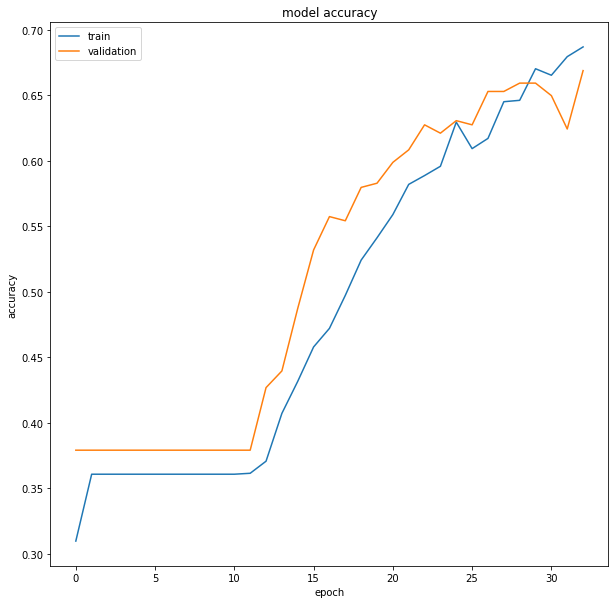

In [162]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

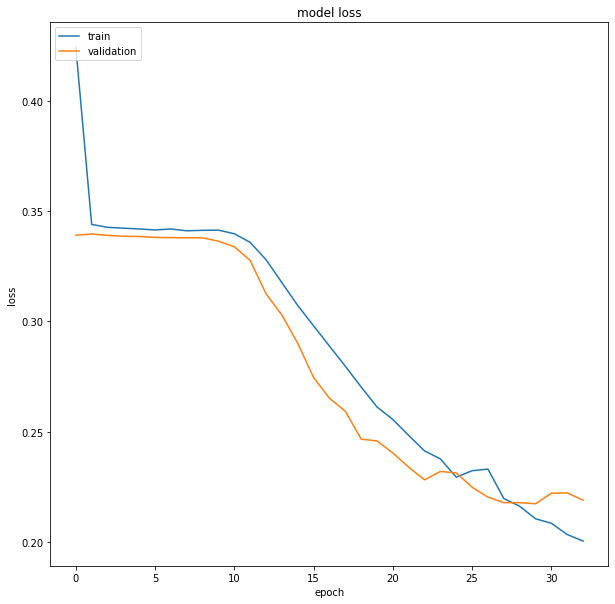

In [163]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [166]:
def Sentiment_LSTM_Model():
  model = models.Sequential()
  model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_VECTOR_LENGTH,
                            weights=[embedding_matrix],
                            input_length=108,
                            trainable=False))
  model.add(SpatialDropout1D(0.4))
  model.add(CuDNNLSTM(176, return_sequences=True))
  model.add(Dropout(0.8))
  model.add(CuDNNLSTM(64, return_sequences=True))
  model.add(Dropout(0.8))
  model.add(CuDNNLSTM(32))
  model.add(Dense(3,activation='sigmoid'))
  return model

In [167]:
sentiment_model = Sentiment_LSTM_Model()
sentiment_model.summary()
sentiment_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 108, 200)          344000    
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 108, 200)         0         
 lDropout1D)                                                     
                                                                 
 cu_dnnlstm_27 (CuDNNLSTM)   (None, 108, 176)          266112    
                                                                 
 dropout_18 (Dropout)        (None, 108, 176)          0         
                                                                 
 cu_dnnlstm_28 (CuDNNLSTM)   (None, 108, 64)           61952     
                                                                 
 dropout_19 (Dropout)        (None, 108, 64)           0         
                                                      

In [168]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]
history = sentiment_model.fit(x_train_sentiment, sentiment_train_label,
            epochs=100,
            callbacks = callbacks,
            validation_data=(x_val_sentiment, sentiment_valid_label),
            verbose=2,
            batch_size=64)

Epoch 1/100
45/45 - 10s - loss: 0.6164 - accuracy: 0.4816 - val_loss: 0.5829 - val_accuracy: 0.5223 - 10s/epoch - 213ms/step
Epoch 2/100
45/45 - 3s - loss: 0.5773 - accuracy: 0.5362 - val_loss: 0.5368 - val_accuracy: 0.5732 - 3s/epoch - 75ms/step
Epoch 3/100
45/45 - 3s - loss: 0.5321 - accuracy: 0.5911 - val_loss: 0.5305 - val_accuracy: 0.5796 - 3s/epoch - 65ms/step
Epoch 4/100
45/45 - 3s - loss: 0.5072 - accuracy: 0.6262 - val_loss: 0.4902 - val_accuracy: 0.6401 - 3s/epoch - 65ms/step
Epoch 5/100
45/45 - 3s - loss: 0.4963 - accuracy: 0.6284 - val_loss: 0.5039 - val_accuracy: 0.6465 - 3s/epoch - 63ms/step
Epoch 6/100
45/45 - 3s - loss: 0.4807 - accuracy: 0.6514 - val_loss: 0.4669 - val_accuracy: 0.6592 - 3s/epoch - 61ms/step
Epoch 7/100
45/45 - 3s - loss: 0.4631 - accuracy: 0.6730 - val_loss: 0.4716 - val_accuracy: 0.6338 - 3s/epoch - 61ms/step
Epoch 8/100
45/45 - 3s - loss: 0.4589 - accuracy: 0.6677 - val_loss: 0.4723 - val_accuracy: 0.6529 - 3s/epoch - 61ms/step
Epoch 9/100
45/45 - 3

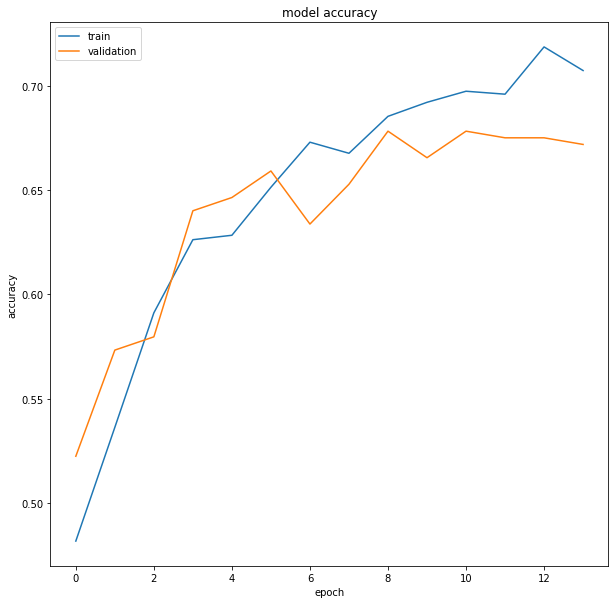

In [169]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

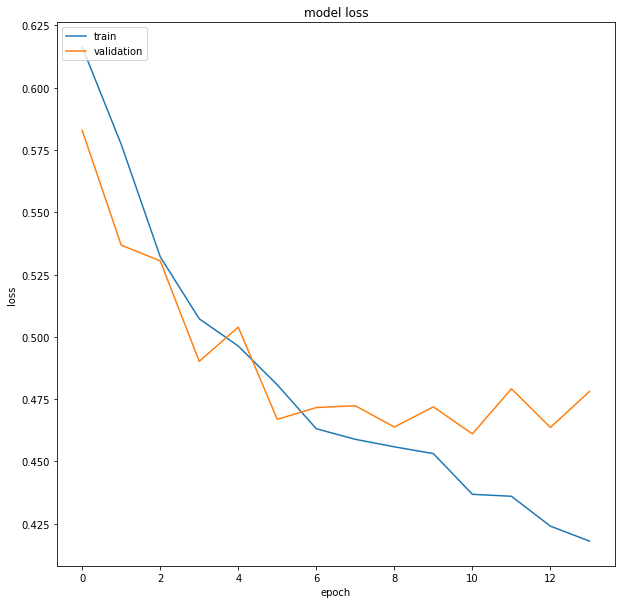

In [170]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()